In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd 
import seaborn as sns
import time

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras import Input, layers, models, optimizers
from keras.callbacks import EarlyStopping
import keras_tuner

import warnings
warnings.filterwarnings('ignore')

2025-06-20 22:17:53.585305: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750457873.768066      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750457873.819357      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Step 1: Problem Description
This project aims to identify metastatic cancer using a labeled dataset of image patches from digital pathology scans. The data is a slightly modified version of the PatchCamelyon (PCam) with duplicates removed.  A sample indicates the presence of cancer if the center 32x32px region of the image contains at least one pixel of tumor tissue.  The 220,025 training images are accompanied by a CSV file to indicate the label (0 - no cancer detected, 1 - cancer detected) of the training images.

The images are 96x96px using RGB color channels.

In [2]:
data_path = "/kaggle/input/histopathologic-cancer-detection"
train_path = os.path.join(data_path, "train")
test_path = os.path.join(data_path, "test")

#Print the first image path to see the structure and file format
print("Sample image:", os.listdir(train_path)[1], '\n')

# Print a few labels from train_labels.csv (0=non-cancerous, 1=cancerous)
df_labels = pd.read_csv(os.path.join(data_path, "train_labels.csv"))
print(df_labels.head())

Sample image: 092d0eedebce504847715ee046b6ad74b57599b4.tif 

                                         id  label
0  f38a6374c348f90b587e046aac6079959adf3835      0
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77      1
2  755db6279dae599ebb4d39a9123cce439965282d      0
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08      0
4  068aba587a4950175d04c680d38943fd488d6a9d      0


In [3]:
df_labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220025 entries, 0 to 220024
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      220025 non-null  object
 1   label   220025 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.4+ MB


## Step 2: Exploratory Data Analysis (EDA) 

### Data Cleaning
The labels must be strings to use class_mode='binary' in the ImageDataGenerator preprocessor in Keras.  The IDs need to include the full file name, which means adding the ".tif" file extension.

In [4]:
df_labels['label'] = df_labels['label'].astype(str)
df_labels['id'] = df_labels['id'].astype(str) + '.tif'
df_labels.iloc[0]

id       f38a6374c348f90b587e046aac6079959adf3835.tif
label                                               0
Name: 0, dtype: object

The initial training set includes over 220k images.  To speed up the model development and evaluation, I am selecting a subset of the training images. 

In [5]:
df_labels_full = df_labels
n_samples = 10000
df_labels = df_labels[:n_samples]

### Split Training and Test
The Kaggle competition includes a test folder, but that requires submitting the notebook.  I am creating train and test data frames to get an initial idea of the model's performance before submitting the notebook for competition scoring.  Stratifying the labels will help ensure that the train and test sets have an equal distribution of non-cancerous and cancerous images.

In [6]:
df_train, df_test = train_test_split(df_labels, test_size=0.2, stratify=df_labels['label'], random_state=42)

### Sample Images
I displayed one non-cancerous and one cancerous image to get an idea of the data set.

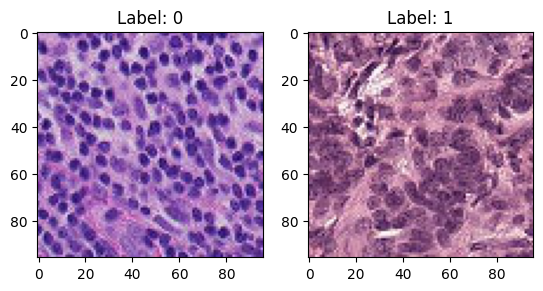

In [7]:
image_0 = df_train.iloc[0]['id']
label_0 = df_train.iloc[0]['label']
image_0 = load_img(f'{train_path}/{image_0}')

image_1 = df_train.iloc[1]['id']
label_1 = df_train.iloc[1]['label']
image_1 = load_img(f'{train_path}/{image_1}')

f, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(image_0)
ax1.set_title(f"Label: {label_0}")
ax2.imshow(image_1)
ax2.set_title(f"Label: {label_1}")
plt.show()

We see that each image is 96x96 pixels with an RGB color scale (as indicated by the third parameter in the shape).

In [8]:
#Get height, width, and number of channels for an image
img_shape = np.asarray(image_0).shape
print(f"Image shape: {img_shape}")

Image shape: (96, 96, 3)


### Data Distribution
I confirmed that the training and test sets have roughly the same distribution of positive and negative labels as the full data set provided by the Kaggle competition.  There is a slight imbalance with the data containing more negative (non-cancerous) samples, so this could be a cause for concern with model performance.

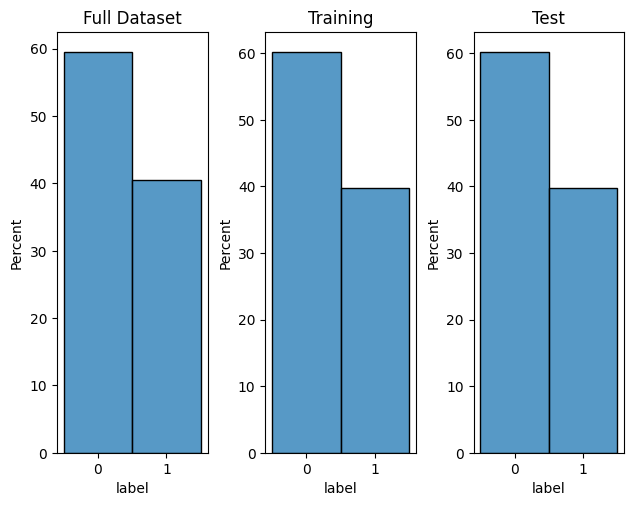

In [9]:
df_sorted = df_test.sort_values('label')

f, (ax1, ax2, ax3) = plt.subplots(1, 3)
plt.tight_layout()
ax1.set_title("Full Dataset")
ax2.set_title("Training")
ax3.set_title("Test")

sns.histplot(ax=ax1, data=df_labels_full, x='label', stat="percent")
sns.histplot(ax=ax2, data=df_train, x='label', stat="percent")
sns.histplot(ax=ax3, data=df_sorted, x='label', stat="percent")
plt.show()

## Step 3:  Model Architecture
I will start with a simple feed-forward Artificial Neural Network (ANN) and then iterate through variations of a Convolutional Neural Network (CNN) model.  I'm starting with an ANN first because I want to see how a simple model will perform before introducing complexity into the model.  I then move on to CNNs because they are well suited for spatial data, such as images.

In [12]:
batch_size = 64
steps_per_epoch = len(df_train) // batch_size

I set up a dictionary to capture model results to display later in the notebook.

In [13]:
model_results = {}

Normalizing pixel values between 0 and 1 is recommended to help improve model performance.  I then use the ImageDataGenerator to preprocess the train and test datasets to help avoid overfitting by applying transformations to the images during model training.

In [14]:
#Normalize pixel values
idg = ImageDataGenerator(rescale=1./255)

train_images = idg.flow_from_dataframe(
    dataframe = df_train,
    directory = train_path,
    x_col = 'id',
    y_col = 'label',
    batch_size = batch_size,
    target_size = img_shape[0:2],
    color_mode = 'rgb',
    class_mode = 'binary',
    shuffle = False
)

Found 8000 validated image filenames belonging to 2 classes.


In [15]:
test_images = idg.flow_from_dataframe(
    dataframe = df_test,
    directory = train_path,
    x_col = 'id',
    y_col = 'label',
    batch_size = batch_size,
    target_size = img_shape[0:2],
    color_mode = 'rgb',
    class_mode = 'binary',
    shuffle = False
)

Found 2000 validated image filenames belonging to 2 classes.


### Sequential Artificial Neural Network
I wanted to start with the most simple model, which is a feed-forward artificial neural network. I chose relu for the hidden layers and sigmoid from the output layer.  Relu is a common choice for hidden layers.  Sigmoid is a good choice for the output layer because it outputs a value between 0 and 1, which fits well with a binary classification output layer.

Note that I attempted a number of different layers with different numbers of units to attempt to improve model performance.  For brevity, I left the best performing configuration below.

In [16]:
early_stopping = EarlyStopping(
    monitor='val_loss',  # Metric to monitor (e.g., validation loss)
    patience=5,       # Number of epochs to wait for improvement
    min_delta=0.001,    # Minimum change in the monitored quantity to qualify as an improvement
    restore_best_weights=True, # Restore model weights from the epoch with the best value of the monitored quantity
    mode='min'        # Direction of the metric (e.g., 'min' for loss, 'max' for accuracy)
)

seq_model = models.Sequential([
    Input(shape = img_shape),
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dense(256, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

seq_model.compile(
    optimizer = optimizers.SGD(),
    loss = 'binary_crossentropy',
    metrics = ['accuracy']
)

start_time = time.time()
seq_results = seq_model.fit(
    train_images,
    validation_data = test_images,
    steps_per_epoch = steps_per_epoch,
    epochs = 50,
    callbacks=[early_stopping]
)
end_time = time.time()

elapsed_time = end_time - start_time

model_results[len(model_results)] = (
    "Sequential ANN", 
    elapsed_time,
    max(seq_results.history['val_accuracy'])
)

I0000 00:00:1750458150.394928      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Epoch 1/50


I0000 00:00:1750458153.248820     101 service.cc:148] XLA service 0x7bd7a4004940 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1750458153.249450     101 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1750458153.434142     101 cuda_dnn.cc:529] Loaded cuDNN version 90300


  1/125 ━━━━━━━━━━━━━━━━━━━━ 3:24 2s/step - accuracy: 0.3438 - loss: 0.9146

I0000 00:00:1750458153.985698     101 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


125/125 ━━━━━━━━━━━━━━━━━━━━ 53s 412ms/step - accuracy: 0.5687 - loss: 0.8410 - val_accuracy: 0.6300 - val_loss: 0.6386
Epoch 2/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 12s 97ms/step - accuracy: 0.6229 - loss: 0.6464 - val_accuracy: 0.6015 - val_loss: 0.6617
Epoch 3/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 11s 89ms/step - accuracy: 0.6421 - loss: 0.6306 - val_accuracy: 0.6890 - val_loss: 0.6157
Epoch 4/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 11s 92ms/step - accuracy: 0.6379 - loss: 0.6367 - val_accuracy: 0.6100 - val_loss: 0.6350
Epoch 5/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 12s 94ms/step - accuracy: 0.6606 - loss: 0.6191 - val_accuracy: 0.6680 - val_loss: 0.6208
Epoch 6/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 12s 100ms/step - accuracy: 0.6639 - loss: 0.6146 - val_accuracy: 0.5745 - val_loss: 0.6413
Epoch 7/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 12s 97ms/step - accuracy: 0.6656 - loss: 0.6045 - val_accuracy: 0.6635 - val_loss: 0.6111
Epoch 8/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 11s 92ms/step - accuracy: 0.6733 - loss: 0.6049 - val_accur

In [17]:
model_results

{0: ('Sequential ANN', 206.4175796508789, 0.6940000057220459)}

#### Commentary
The model performed slightly better than chance with a maximum validation accuracy of 0.6940, so there is room for improvement.

### Convolutional Neural Network
CNNs do well at processing spatial data, such as in this use case of processing images.  I created a simple CNN with one convolution/pooling layer before flattening and then using the final dense layer to create the 0/1 classification output.

In [18]:
cnn_model = models.Sequential([
    Input(shape = img_shape),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(1, activation='sigmoid')
])

cnn_model.compile(
    optimizer = optimizers.SGD(),
    loss = 'binary_crossentropy',
    metrics = ['accuracy']
)

start_time = time.time()
cnn_results = cnn_model.fit(
    train_images,
    validation_data = test_images,
    steps_per_epoch = steps_per_epoch,
    epochs = 50,
    callbacks=[early_stopping]
)
end_time = time.time()

elapsed_time = end_time - start_time

model_results[len(model_results)] = (
    "CNN", 
    elapsed_time,
    max(cnn_results.history['val_accuracy'])
)

Epoch 1/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 14s 99ms/step - accuracy: 0.6090 - loss: 0.7952 - val_accuracy: 0.6635 - val_loss: 0.5953
Epoch 2/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 12s 94ms/step - accuracy: 0.6832 - loss: 0.5933 - val_accuracy: 0.6800 - val_loss: 0.5705
Epoch 3/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 12s 96ms/step - accuracy: 0.7109 - loss: 0.5672 - val_accuracy: 0.7460 - val_loss: 0.5682
Epoch 4/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 13s 101ms/step - accuracy: 0.7272 - loss: 0.5481 - val_accuracy: 0.7715 - val_loss: 0.5315
Epoch 5/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 12s 99ms/step - accuracy: 0.7529 - loss: 0.5184 - val_accuracy: 0.6965 - val_loss: 0.5795
Epoch 6/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 12s 97ms/step - accuracy: 0.7442 - loss: 0.5358 - val_accuracy: 0.7540 - val_loss: 0.5371
Epoch 7/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 12s 94ms/step - accuracy: 0.7564 - loss: 0.5180 - val_accuracy: 0.7805 - val_loss: 0.4921
Epoch 8/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 12s 96ms/step - accuracy: 0.7633 - loss: 0.5133 -

In [19]:
model_results

{0: ('Sequential ANN', 206.4175796508789, 0.6940000057220459),
 1: ('CNN', 205.73615622520447, 0.7835000157356262)}

#### Commentary
Adding the convolution/pooling layer significantly improved validation accuracy from 0.6940 to 0.7835.  The training time was roughly the same, so the improved accuracy is worth the added model complexity.

### CNN - Additional Layers
The CNN showed a noticeable improvement in accuracy over the simple, feed-forward ANN.  I want to adjust the architecture by introducing a few more convolution/pooling layers to see if I can improve the predictive power of the model.

In [20]:
cnn_model_addl = models.Sequential([
    Input(shape = img_shape),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(256, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(1, activation='sigmoid')
])

cnn_model_addl.compile(
    optimizer = optimizers.SGD(),
    loss = 'binary_crossentropy',
    metrics = ['accuracy']
)

start_time = time.time()
cnn_results_addl = cnn_model_addl.fit(
    train_images,
    validation_data = test_images,
    steps_per_epoch = steps_per_epoch,
    epochs = 50,
    callbacks=[early_stopping]
)
end_time = time.time()

elapsed_time = end_time - start_time

model_results[len(model_results)] = (
    "CNN - Additional Layers", 
    elapsed_time,
    max(cnn_results_addl.history['val_accuracy'])
)

Epoch 1/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 16s 109ms/step - accuracy: 0.5940 - loss: 0.6720 - val_accuracy: 0.6020 - val_loss: 0.6647
Epoch 2/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 12s 100ms/step - accuracy: 0.6074 - loss: 0.6608 - val_accuracy: 0.6020 - val_loss: 0.6576
Epoch 3/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 12s 93ms/step - accuracy: 0.6020 - loss: 0.6548 - val_accuracy: 0.5995 - val_loss: 0.6451
Epoch 4/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 13s 100ms/step - accuracy: 0.6220 - loss: 0.6369 - val_accuracy: 0.6620 - val_loss: 0.6130
Epoch 5/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 12s 97ms/step - accuracy: 0.6533 - loss: 0.6204 - val_accuracy: 0.7110 - val_loss: 0.6241
Epoch 6/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 13s 102ms/step - accuracy: 0.6968 - loss: 0.5997 - val_accuracy: 0.7530 - val_loss: 0.5570
Epoch 7/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 12s 99ms/step - accuracy: 0.7149 - loss: 0.5714 - val_accuracy: 0.7660 - val_loss: 0.5490
Epoch 8/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 12s 94ms/step - accuracy: 0.7280 - loss: 0.555

In [21]:
model_results

{0: ('Sequential ANN', 206.4175796508789, 0.6940000057220459),
 1: ('CNN', 205.73615622520447, 0.7835000157356262),
 2: ('CNN - Additional Layers', 599.0216431617737, 0.8195000290870667)}

#### Commentary
The additional layers improved validation accuracy from 0.7835 to 0.8195.  However, the training time more than doubled.  The slight increase in accuracy may not be worth the additional training time if the data set was larger.

### CNN - Augmentation
Adding augmentation can improve the generalization of a model by modifying images through techniques such as rotation. The ImageDataGenerator below will normalize the pixels to values between 0 and 1 as it did above.  However, this version will also randomly flip images horizontally, vertically, and rotate between -30 and 30 degrees. I will reuse the CNN model with the additional convolution/pooling layers and feed in the augmented images.

In [22]:
aug = ImageDataGenerator(
    rescale=1./255,        
    horizontal_flip=True,
    vertical_flip = True,
    rotation_range=20
)  

train_images_aug = aug.flow_from_dataframe(
    dataframe = df_train,
    directory = train_path,
    x_col = 'id',
    y_col = 'label',
    batch_size = batch_size,
    target_size = img_shape[0:2],
    color_mode = 'rgb',
    class_mode = 'binary',
    shuffle = False
)

test_images_aug = aug.flow_from_dataframe(
    dataframe = df_test,
    directory = train_path,
    x_col = 'id',
    y_col = 'label',
    batch_size = batch_size,
    target_size = img_shape[0:2],
    color_mode = 'rgb',
    class_mode = 'binary',
    shuffle = False
)


Found 8000 validated image filenames belonging to 2 classes.
Found 2000 validated image filenames belonging to 2 classes.


In [23]:
cnn_model_aug = models.Sequential([
    Input(shape = img_shape),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(256, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(1, activation='sigmoid')
])

cnn_model_aug.compile(
    optimizer = optimizers.SGD(),
    loss = 'binary_crossentropy',
    metrics = ['accuracy']
)

start_time = time.time()
cnn_results_aug = cnn_model_aug.fit(
    train_images_aug,
    validation_data = test_images_aug,
    steps_per_epoch = steps_per_epoch,
    epochs = 50,
    callbacks=[early_stopping]
)
end_time = time.time()

elapsed_time = end_time - start_time

model_results[len(model_results)] = (
    "CNN - Augmentation", 
    elapsed_time,
    max(cnn_results_aug.history['val_accuracy'])
)

Epoch 1/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 32s 242ms/step - accuracy: 0.6036 - loss: 0.6723 - val_accuracy: 0.6020 - val_loss: 0.6656
Epoch 2/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 29s 236ms/step - accuracy: 0.6157 - loss: 0.6569 - val_accuracy: 0.6015 - val_loss: 0.6630
Epoch 3/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 30s 237ms/step - accuracy: 0.5957 - loss: 0.6624 - val_accuracy: 0.6010 - val_loss: 0.6563
Epoch 4/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 30s 240ms/step - accuracy: 0.6068 - loss: 0.6494 - val_accuracy: 0.6205 - val_loss: 0.6388
Epoch 5/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 30s 239ms/step - accuracy: 0.6413 - loss: 0.6295 - val_accuracy: 0.6250 - val_loss: 0.6187
Epoch 6/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 30s 237ms/step - accuracy: 0.6669 - loss: 0.6195 - val_accuracy: 0.7065 - val_loss: 0.6023
Epoch 7/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 30s 238ms/step - accuracy: 0.6954 - loss: 0.5984 - val_accuracy: 0.7450 - val_loss: 0.5583
Epoch 8/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 30s 240ms/step - accuracy: 0.7005 - loss: 0

In [24]:
model_results

{0: ('Sequential ANN', 206.4175796508789, 0.6940000057220459),
 1: ('CNN', 205.73615622520447, 0.7835000157356262),
 2: ('CNN - Additional Layers', 599.0216431617737, 0.8195000290870667),
 3: ('CNN - Augmentation', 926.2230312824249, 0.7960000038146973)}

#### Commentary
The augmentation decreased validation accuracy from 0.8195 to 0.7960.  The training time significantly increased, so I will not use the augmentation going forward.

### CNN - Regularization
Regularization is a technique to prevent overfitting the model to training data by reducing the impact of feature weights on the loss function.  I applied dropout regularization to conv2d_2, conv2d_3, and conv2d_4 layers because those layers have the highest number of parameters.  The regularization will drops some random nodes in those layers with a probability of 0.1.

In [25]:
cnn_model_addl.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)                    │ (None, 94, 94, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 47, 47, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 45, 45, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 20, 20, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 10, 10, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 8, 8, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 4, 4, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │           4,097 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 392,515 (1.50 MB)

 Trainable params: 392,513 (1.50 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

In [26]:
cnn_model_reg = models.Sequential([
    Input(shape = img_shape),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.Dropout(0.1),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.Dropout(0.1),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(256, (3, 3), activation='relu'),
    layers.Dropout(0.1),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(1, activation='sigmoid')
])

cnn_model_reg.compile(
    optimizer = optimizers.SGD(),
    loss = 'binary_crossentropy',
    metrics = ['accuracy']
)

start_time = time.time()
cnn_results_reg = cnn_model_reg.fit(
    train_images,
    validation_data = test_images,
    steps_per_epoch = steps_per_epoch,
    epochs = 50,
    callbacks=[early_stopping]
)
end_time = time.time()

elapsed_time = end_time - start_time

model_results[len(model_results)] = (
    "CNN - Regularization", 
    elapsed_time,
    max(cnn_results_reg.history['val_accuracy'])
)

Epoch 1/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 17s 106ms/step - accuracy: 0.5870 - loss: 0.6730 - val_accuracy: 0.6020 - val_loss: 0.6640
Epoch 2/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 12s 97ms/step - accuracy: 0.6075 - loss: 0.6553 - val_accuracy: 0.6220 - val_loss: 0.6595
Epoch 3/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 12s 93ms/step - accuracy: 0.6294 - loss: 0.6419 - val_accuracy: 0.7195 - val_loss: 0.6369
Epoch 4/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 12s 93ms/step - accuracy: 0.6548 - loss: 0.6290 - val_accuracy: 0.6975 - val_loss: 0.6104
Epoch 5/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 12s 99ms/step - accuracy: 0.6936 - loss: 0.6027 - val_accuracy: 0.6520 - val_loss: 0.5983
Epoch 6/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 12s 97ms/step - accuracy: 0.6928 - loss: 0.5945 - val_accuracy: 0.6345 - val_loss: 0.5981
Epoch 7/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 13s 100ms/step - accuracy: 0.6941 - loss: 0.5893 - val_accuracy: 0.7525 - val_loss: 0.5550
Epoch 8/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 12s 96ms/step - accuracy: 0.7327 - loss: 0.5467 

In [27]:
model_results

{0: ('Sequential ANN', 206.4175796508789, 0.6940000057220459),
 1: ('CNN', 205.73615622520447, 0.7835000157356262),
 2: ('CNN - Additional Layers', 599.0216431617737, 0.8195000290870667),
 3: ('CNN - Augmentation', 926.2230312824249, 0.7960000038146973),
 4: ('CNN - Regularization', 560.2503824234009, 0.828000009059906)}

#### Commentary
The validation accuracy of 0.8280 is the highest of the models thus far, and the training time is similar to what we saw with the CNN without the regularization (i.e., "CNN - Additional Layers").

### Hyperparameter Tuning
I used the Keras Tuner to find the best learning rate hyperparameter for CNN model with regularization from above.

In [30]:
def build_model(hp):
    model = models.Sequential([
        Input(shape = img_shape),
        layers.Conv2D(32, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.Dropout(0.1),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.Dropout(0.1),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(256, (3, 3), activation='relu'),
        layers.Dropout(0.1),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(1, activation='sigmoid')
    ])

    learning_rates = hp.Choice('learning_rate', values=[0.01, 0.001, 0.0001])
    model.compile(
        optimizer = optimizers.SGD(learning_rate=learning_rates),
        loss = 'binary_crossentropy',
        metrics = ['accuracy']
    )
    return model

tuner = keras_tuner.RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=5)

In [31]:
tuner.search(
    train_images,
    validation_data = test_images,
    steps_per_epoch = steps_per_epoch,
    epochs = 50,
    callbacks=[early_stopping]
)

Trial 3 Complete [00h 09m 20s]
val_loss: 0.4229094684123993

Best val_loss So Far: 0.4229094684123993
Total elapsed time: 00h 22m 46s


In [48]:
#Save the best model to use for competition submission
best_model = tuner.get_best_models()[0]

#### Commentary
The best learning rate found was 0.01, which is the learning rate used in the CNN models above because 0.01 is the default learning rate for the SGD optimizer.

In [45]:
tuner.get_best_hyperparameters()[0].get('learning_rate')

0.01

## Step 4: Results and Analysis
The CNN model with regularization had the best validation accuracy with 0.8280, and the training time was lower than seen with the augmented images.  Therefore, the CNN model with regularization is the best model I found.

In [37]:
df = pd.DataFrame.from_dict(model_results, orient='index')
df.columns = ['Model', 'Training Time', 'Max Validation Accuracy']
df.head()

,Model,Training Time,Max Validation Accuracy
0,Sequential ANN,206.417580,0.6940
1,CNN,205.736156,0.7835
2,CNN - Additional Layers,599.021643,0.8195
3,CNN - Augmentation,926.223031,0.7960
4,CNN - Regularization,560.250382,0.8280


The CNN with regularization shows similar results for training and test loss for much of the graph.  There are a few spikes in the test loss.  The final spike in test loss indicates that the test loss may be starting to consistently diverge from the training loss.  In which case, stopping the model training after fewer epochs could improve the models performance.

In [33]:
def show_model_history(history):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
    plt.tight_layout()
    ax1.set_title("Loss")
    ax2.set_title("Accuracy")

    ax1.plot(history.epoch, history.history["loss"], label="Train")
    ax1.plot(history.epoch, history.history["val_loss"], label="Test")
    ax2.plot(history.epoch, history.history["accuracy"], label="Train")
    ax2.plot(history.epoch, history.history["val_accuracy"], label="Test")

    ax1.legend()
    ax2.legend()
    plt.show()

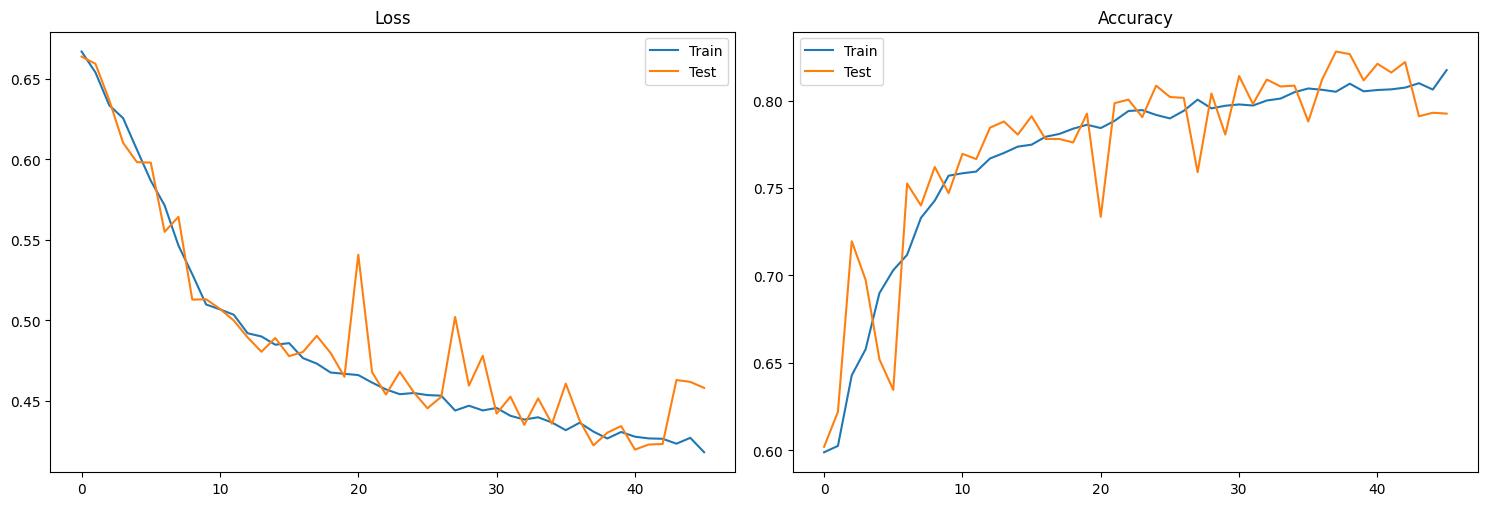

In [36]:
show_model_history(cnn_results_reg)

## Step 5:  Conclusion

### Learnings and Takeaways
There appears to be both an art and a science to create neural networks.  Choosing the right architecture and hyperparameters significantly impact both the training time and prediction power of the model.

### What did and did not help improve the performance of your models? 
The image augmentation did not improve model performance.  This could be due to using too many image transformations or a dataset that was not large enough.  Experimenting with fewer image transformations or increasing the training set size may improve the model's performance.

### What improvements could you try in the future?
Adjusting the number of convolution/pooling layers impacted the performance of the model.  Specifically, the more complex the model, the longer the training time.  Iteratively simplifying the model while monitoring the accuracy would improve training time.

Using a larger training sample should also improve the accuracy of the model.  However, this improved accuracy comes at the cost of training time.  With enough time and compute power, I would have liked to use the full training set to improve the predictive power of the model.

Given more time, I could experiment with tuning more hyperparameters.  For example, using a different number of units in each CNN layer and/or using a different dropout rate could improve the model's performance.

## Submit to Competition
The remainder of this notebook (except for the references section) is the code needed to create the submission output for the Kaggle competition.

### Load Test Images

In [ ]:
df_submission = pd.DataFrame({'id': os.listdir(test_path)})
df_submission.head()

In [ ]:
df_submission.info()

In [ ]:
submission_images = idg.flow_from_dataframe(
    dataframe = df_submission,
    directory = test_path,
    x_col = 'id',
    y_col = None,
    batch_size = 32,
    target_size = img_shape[0:2],
    color_mode = 'rgb',
    class_mode = None,
    shuffle = False
)

### Predict from Model

In [ ]:
y_pred = best_model.predict(submission_images)

To submit to the Kaggle competition, I need to remove the ".tif" file extension from the labels and convert the predictions to labels of 0 and 1.

In [ ]:
df_submission['id'] = df_submission['id'].str[:-4]
df_submission['label'] = (y_pred > 0.5).astype("int32")
print(df_submission.head())

In [ ]:
df_submission['label'].value_counts()

In [ ]:
df_submission.to_csv("submission.csv", index=False)

References:
1. Will Cukierski. Histopathologic Cancer Detection. https://kaggle.com/competitions/histopathologic-cancer-detection, 2018. Kaggle.
2. https://keras.io/api/callbacks/early_stopping/
3. https://keras.io/keras_tuner/
4. https://www.tensorflow.org/tutorials/images/cnn
5. https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator#flow_from_dataframe
6. https://www.geeksforgeeks.org/deep-learning/keras-sequential-class/#introduction-to-keras-and-the-sequential-class
7. https://medium.com/intelligentmachines/convolutional-neural-network-and-regularization-techniques-with-tensorflow-and-keras-5a09e6e65dc7

